<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-1">Dependencies</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2">Functions</a></span></li><li><span><a href="#Paths" data-toc-modified-id="Paths-3">Paths</a></span></li><li><span><a href="#Main" data-toc-modified-id="Main-4">Main</a></span></li><li><span><a href="#Determine-immune-genes" data-toc-modified-id="Determine-immune-genes-5">Determine immune genes</a></span><ul class="toc-item"><li><span><a href="#1--Bagaev-et-al-Immune-cell-compendium" data-toc-modified-id="1--Bagaev-et-al-Immune-cell-compendium-5.1">1- Bagaev et al Immune cell compendium</a></span></li><li><span><a href="#2--single-cell-data-from-protein-atlas" data-toc-modified-id="2--single-cell-data-from-protein-atlas-5.2">2- single-cell data from protein atlas</a></span></li><li><span><a href="#3--protein-atlas-tissue-specificity-data" data-toc-modified-id="3--protein-atlas-tissue-specificity-data-5.3">3- protein atlas tissue specificity data</a></span></li><li><span><a href="#4--ImmuneScore-genes-from-ESTIMATE" data-toc-modified-id="4--ImmuneScore-genes-from-ESTIMATE-5.4">4- ImmuneScore genes from ESTIMATE</a></span></li><li><span><a href="#Compile-all-immune-genes" data-toc-modified-id="Compile-all-immune-genes-5.5">Compile all immune genes</a></span></li></ul></li><li><span><a href="#Filter-out-genes-expressed-in-pediatric-tumour/non-immune-cells" data-toc-modified-id="Filter-out-genes-expressed-in-pediatric-tumour/non-immune-cells-6">Filter out genes expressed in pediatric tumour/non-immune cells</a></span><ul class="toc-item"><li><span><a href="#1--PDX" data-toc-modified-id="1--PDX-6.1">1- PDX</a></span></li><li><span><a href="#2--scRNA" data-toc-modified-id="2--scRNA-6.2">2- scRNA</a></span><ul class="toc-item"><li><span><a href="#1--Frank's-NBL" data-toc-modified-id="1--Frank's-NBL-6.2.1">1- Frank's NBL</a></span></li><li><span><a href="#2--Gojo's-EPN" data-toc-modified-id="2--Gojo's-EPN-6.2.2">2- Gojo's EPN</a></span></li><li><span><a href="#3--Gillen's-EPN" data-toc-modified-id="3--Gillen's-EPN-6.2.3">3- Gillen's EPN</a></span></li></ul></li><li><span><a href="#3--Cell-lines-from-CBTN" data-toc-modified-id="3--Cell-lines-from-CBTN-6.3">3- Cell lines from CBTN</a></span></li><li><span><a href="#Bind-all" data-toc-modified-id="Bind-all-6.4">Bind all</a></span></li></ul></li></ul></div>

# Dependencies

In [1]:
options(scipen = 999)

In [2]:
library(Biobase)
library(tidyr)
library(biomaRt)

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bi

# Functions

In [3]:
source("~/OneDrive - UHN/R_src/ggplot2_theme.R")

In [4]:
longtowidefx <- function(long_exp_matrix){
    wide_exp_matrix <- tidyr::spread(long_exp_matrix, 
                              key = "sample", 
                              value = "tpm")
    return(wide_exp_matrix)
}

In [5]:
mcentr <- function(x) {
    meds <- median(x, na.rm=T)
    mads <- mad(x, na.rm=T)
    if (mads == 0) {
        rep(0, length(x))} else {
        (x - meds) / mads}
}

# Paths

In [6]:
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/IPD2/Manifests/"
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/IPD2/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/IPD2/Plots/"

# Main

In [7]:
load(paste0(datapath, "exp_mat/IPD_ExprSet_log2_combat.RData"))

In [8]:
vars <- pData(IPD_Set_log2_combat)
tpms <- exprs(IPD_Set_log2_combat)

In [9]:
table(vars$CRI_cluster)


  1   2   3   4   5   6 
 64  26 148 554 110   6 

In [10]:
#rename TCGA clusters
vars$CRI_cluster[which(vars$CRI_cluster == 1)] <- "Wound Healing"
vars$CRI_cluster[which(vars$CRI_cluster == 2)] <- "IFN-gamma dominant"
vars$CRI_cluster[which(vars$CRI_cluster == 3)] <- "Inflammatory"
vars$CRI_cluster[which(vars$CRI_cluster == 4)] <- "Lymphocyte depleted"
vars$CRI_cluster[which(vars$CRI_cluster == 5)] <- "Immunologically quiet"
vars$CRI_cluster[which(vars$CRI_cluster == 6)] <- "TGFbeta dominant"

# Determine immune genes

## 1- Bagaev et al Immune cell compendium

In [11]:
# TableS2 from Bagaev et al
bagaev_median <- read.csv(file = paste0(datapath, "TME_clusters/immunecells_compendium_Median.csv"),
                          header = T, stringsAsFactors = F, row.names = 1, check.names = F, skip = 1)

In [12]:
head(bagaev_median)

,T_helpers,CD4_T_cells,Tregs,CD8_T_cells,NK_cells,B_cells,Plasmacytoid_dendritic_cells,Dendritic_cells,Myeloid_cells,Monocytes,Macrophages,Macrophages_infected,Neutrophils,Fibroblasts,Endothelium,Melanoma,Melanoma Primary,Melanoma Metastasis
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
A1CF,0.08406795,0.06069306,0.07641884,0.1037934,0.04505663,0.1237914,0.07698022,0.06204041,0.06235984,0.08430018,0.02002451,0.02304037,0.052535261,0.01838697,0.01734924,0.03327247,0.01692311,0.01555221
A2M,0.81805629,0.12240906,0.29794129,2.7971061,1.21782913,0.0716964,2.04524029,1.95675809,3.92244810,0.43032473,7.94848369,8.44845815,0.009030409,1.67354797,3.17858054,4.74040310,8.17271950,8.64940635
A2ML1,0.31759809,0.16653402,0.43406171,0.4959649,0.36339632,0.8024651,0.20140618,0.25896520,0.56097638,0.43838215,0.11274752,0.07202006,0.408781112,0.07351740,0.08057154,0.12526228,0.74466755,0.20275951
A3GALT2,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.0000000,0.00000000,0.00000000,0.15485671,0.33359313,0.00000000,0.00000000,0.833714164,0.00000000,0.00000000,0.08447119,0.05212233,0.04590313
A4GALT,0.00000000,0.00000000,0.00000000,0.0000000,0.02202133,0.1131194,1.75907437,0.11421613,2.28751220,0.00000000,1.76635257,1.69764588,0.000000000,4.36188996,4.01562797,0.54605123,2.19565010,2.14657694


Median center MAD scale

In [13]:
bagaev_mcentr <- (bagaev_median - median(unlist(bagaev_median)))/mad(unlist(bagaev_median))

In [14]:
summary(unlist(bagaev_median))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0379  1.8536  2.4660  4.4165 16.3842 

In [15]:
summary(unlist(bagaev_mcentr))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.6745 -0.6607  0.0000  0.2228  0.9326  5.2874 

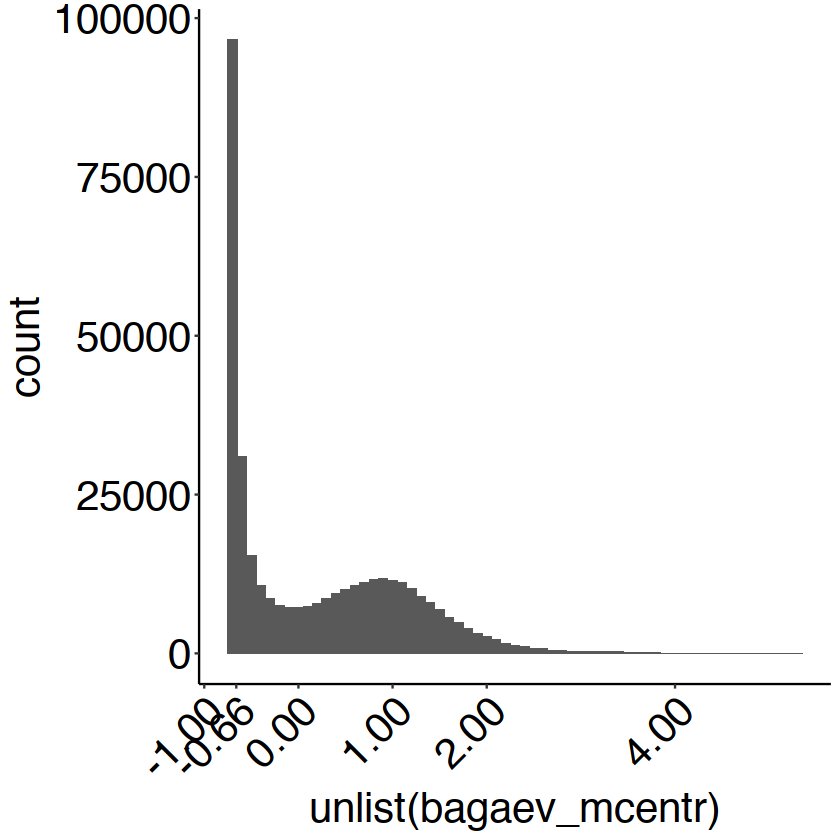

In [16]:
ggplot() + geom_histogram(aes(unlist(bagaev_mcentr)), binwidth = 0.1) + myaxis + myplot + 
scale_x_continuous(breaks = c(-1, -0.66,0,1,2,4))

Expressed genes are expressed > 75th percentile in at least one cell type

In [17]:
bagaev_expressed_genes <- rownames(bagaev_mcentr)[rowSums(bagaev_mcentr > quantile(unlist(bagaev_mcentr),0.75)) >= 1]

In [18]:
length(bagaev_expressed_genes)

[1] 9897

In [19]:
# med center genes across all celltypes
bagaev_median_mcentr <- t(apply(bagaev_median,1, mcentr))

In [20]:
colnames(bagaev_median_mcentr) <- colnames(bagaev_median)

In [21]:
head(bagaev_median_mcentr)

,T_helpers,CD4_T_cells,Tregs,CD8_T_cells,NK_cells,B_cells,Plasmacytoid_dendritic_cells,Dendritic_cells,Myeloid_cells,Monocytes,Macrophages,Macrophages_infected,Neutrophils,Fibroblasts,Endothelium,Melanoma,Melanoma Primary,Melanoma Metastasis
A1BG,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
A1CF,0.6716501,0.09978925,0.4845164,1.1542292,-0.2827521,1.6434751,0.49825050,0.13275183,0.1405665,0.6773315,-0.8951566,-0.8213745,-0.09978925,-0.9352186,-0.9606063,-0.5710485,-0.9710317,-1.0045704
A2M,-0.4455402,-0.70754673,-0.6414348,0.2998434,-0.2949709,-0.7266470,0.01666284,-0.01666284,0.7236889,-0.5915743,2.2400433,2.4283522,-0.75024934,-0.1233303,0.4435208,1.0317611,2.3244988,2.5040368
A2ML1,0.1263010,-0.52451253,0.6280490,0.8947398,0.3236087,2.2152028,-0.37427647,-0.12630096,1.1748222,0.6466623,-0.7562353,-0.9316971,0.51913522,-0.9252463,-0.8948557,-0.7023192,1.9661996,-0.3684461
A3GALT2,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
A4GALT,-0.6744908,-0.67449076,-0.6744908,-0.6744908,-0.6294993,-0.4433783,2.91944551,-0.44113764,3.9990882,-0.6744908,2.9343155,2.7939420,-0.67449076,8.2372157,7.5297735,0.4411376,3.8114063,3.7111457


In [22]:
# get a list of tables with  differences across celltype medians for each gene
diff_gen_list <- mclapply(rownames(bagaev_median_mcentr), function(x){
    mygen <- x
    gen_df <- bagaev_median_mcentr[mygen,]
    #get m-score difference across cell types
    tab_diff <- outer(gen_df, gen_df, "-")
    
    #keep immune cells in rows and non-immune in cols   
    return(tab_diff[1:13,14:18])    
})

names(diff_gen_list) <- rownames(bagaev_median_mcentr)

In [23]:
#row value - col value
diff_gen_list[["CD8A"]]

,Fibroblasts,Endothelium,Melanoma,Melanoma Primary,Melanoma Metastasis
T_helpers,0.97997630,0.97997630,0.92962668,-1.2075020,-2.386453
CD4_T_cells,1.20404458,1.20404458,1.15369496,-0.9834337,-2.162385
Tregs,0.97705217,0.97705217,0.92670255,-1.2104261,-2.389377
CD8_T_cells,9.28423066,9.28423066,9.23388103,7.0967524,5.917801
NK_cells,5.92580988,5.92580988,5.87546026,3.7383316,2.559380
B_cells,0.41008628,0.41008628,0.35973666,-1.7773920,-2.956343
Plasmacytoid_dendritic_cells,1.83737953,1.83737953,1.78702990,-0.3500988,-1.529050
Dendritic_cells,0.51221251,0.51221251,0.46186289,-1.6752658,-2.854217
Myeloid_cells,0.79068485,0.79068485,0.74033522,-1.3967934,-2.575745
Monocytes,0.65941584,0.65941584,0.60906622,-1.5280624,-2.707014


Select genes if any immune cells express >=2 mad compared to all nonimmune cells

In [24]:
diff_gen_list_immune <- lapply(diff_gen_list, function(x) x[ rowSums(x >= 2) == 5,,drop = F])

In [25]:
# rmeove empty lists
diff_gen_list_immune <- diff_gen_list_immune[sapply(diff_gen_list_immune, function(x) length(unlist(x))) >= 5]

In [26]:
head(diff_gen_list_immune)

,Fibroblasts,Endothelium,Melanoma,Melanoma Primary,Melanoma Metastasis
B_cells,2.578694,2.604081,2.214524,2.614507,2.648045
,Fibroblasts,Endothelium,Melanoma,Melanoma Primary,Melanoma Metastasis
Myeloid_cells,4.52825,8.814255,7.259208,7.441095,7.465274
,Fibroblasts,Endothelium,Melanoma,Melanoma Primary,Melanoma Metastasis
NK_cells,3.102306,3.132543,2.538271,2.620217,2.795156
B_cells,5.223205,5.253442,4.659171,4.741116,4.916055
Monocytes,3.200807,3.231044,2.636772,2.718718,2.893657
,Fibroblasts,Endothelium,Melanoma,Melanoma Primary,Melanoma Metastasis
Neutrophils,5.495904,4.814888,4.827939,3.555892,3.772472
,Fibroblasts,Endothelium,Melanoma,Melanoma Primary,Melanoma Metastasis


In [27]:
length(diff_gen_list_immune)

[1] 3733

In [28]:
diff_gen_list_immune_expressed <- diff_gen_list_immune[names(diff_gen_list_immune) %in% bagaev_expressed_genes]

In [29]:
length(diff_gen_list_immune_expressed)

[1] 1958

In [30]:
compendium_immune_genes <- names(diff_gen_list_immune_expressed)

In [31]:
head(compendium_immune_genes)

[1] "AATK"    "ABCA7"   "ABCB1"   "ABCB4"   "ABHD15"  "ABHD17A"

Selected 1958 genes that are expressed more than 75th (of the entire dataset) in at least one cell type AND have >2 mad difference in expression between at least one immune celltype and all non-immune celltypes

## 2- single-cell data from protein atlas

In [32]:
proteinatlas <- read.csv(paste0(datapath, "TME_clusters/proteinatlas_v20.1.csv"), header = TRUE, stringsAsFactors = FALSE)

In [33]:
dim(proteinatlas)

[1] 19670   292

In [34]:
#remove irrelevant columns
rmcols <- colnames(proteinatlas)[ grepl("Cell.RNA...", colnames(proteinatlas))]
rmcols <- c(rmcols, colnames(proteinatlas)[ grepl("mouse", colnames(proteinatlas))])
rmcols <- c(rmcols, colnames(proteinatlas)[ grepl("pig", colnames(proteinatlas))])
rmcols <- c(rmcols, colnames(proteinatlas)[ grepl("Pathology", colnames(proteinatlas))])
rmcols <- c(rmcols, colnames(proteinatlas)[ grepl("score", colnames(proteinatlas))])
rmcols <- c(rmcols, colnames(proteinatlas)[ grepl("distribution", colnames(proteinatlas))])
rmcols <- c(rmcols, colnames(proteinatlas)[ grepl("Blood.concentration", colnames(proteinatlas))])
rmcols <- c(rmcols, colnames(proteinatlas)[ grepl("Secretome", colnames(proteinatlas))])
rmcols <- c(rmcols, colnames(proteinatlas)[ grepl("Subcellular", colnames(proteinatlas))])
rmcols <- c(rmcols, colnames(proteinatlas)[ grepl("Brain.RNA", colnames(proteinatlas))])

In [35]:
proteinatlas <- proteinatlas[,! colnames(proteinatlas) %in% rmcols]

In [36]:
# Get single-cell columns and dedup genes
sc_rna <- proteinatlas[!duplicated(proteinatlas$Gene),grepl("Single.Cell.Type", colnames(proteinatlas))]
rownames(sc_rna) <- proteinatlas$Gene[!duplicated(proteinatlas$Gene)]

In [37]:
colnames(sc_rna)

[1] "Single.Cell.Type.RNA...Alveolar.cells.type.1..NX."     
 [2] "Single.Cell.Type.RNA...Alveolar.cells.type.2..NX."     
 [3] "Single.Cell.Type.RNA...B.cells..NX."                   
 [4] "Single.Cell.Type.RNA...Basal.glandular.cells..NX."     
 [5] "Single.Cell.Type.RNA...Basal.keratinocytes..NX."       
 [6] "Single.Cell.Type.RNA...Bipolar.cells..NX."             
 [7] "Single.Cell.Type.RNA...Cardiomyocytes..NX."            
 [8] "Single.Cell.Type.RNA...Cholangiocytes..NX."            
 [9] "Single.Cell.Type.RNA...Ciliated.cells..NX."            
[10] "Single.Cell.Type.RNA...Club.cells..NX."                
[11] "Single.Cell.Type.RNA...Collecting.duct.cells..NX."     
[12] "Single.Cell.Type.RNA...Cone.photoreceptor.cells..NX."  
[13] "Single.Cell.Type.RNA...Cytotrophoblasts..NX."          
[14] "Single.Cell.Type.RNA...Distal.tubular.cells..NX."      
[15] "Single.Cell.Type.RNA...Ductal.cells..NX."              
[16] "Single.Cell.Type.RNA...Early.spermatids..NX."          
[17] "Single.Cell.Type.RNA...Endothelial.cells..NX."         
[18] "Single.Cell.Type.RNA...Enterocytes..NX."               
[19] "Single.Cell.Type.RNA...Erythroid.cells..NX."           
[20] "Single.Cell.Type.RNA...Exocrine.glandular.cells..NX."  
[21] "Single.Cell.Type.RNA...Extravillous.trophoblasts..NX." 
[22] "Single.Cell.Type.RNA...Fibroblasts..NX."               
[23] "Single.Cell.Type.RNA...Glandular.cells..NX."           
[24] "Single.Cell.Type.RNA...granulocytes..NX."              
[25] "Single.Cell.Type.RNA...Hepatocytes..NX."               
[26] "Single.Cell.Type.RNA...Hofbauer.cells..NX."            
[27] "Single.Cell.Type.RNA...Horizontal.cells..NX."          
[28] "Single.Cell.Type.RNA...Intestinal.endocrine.cells..NX."
[29] "Single.Cell.Type.RNA...Ito.cells..NX."                 
[30] "Single.Cell.Type.RNA...Kupffer.cells..NX."             
[31] "Single.Cell.Type.RNA...Late.spermatids..NX."           
[32] "Single.Cell.Type.RNA...Leydig.cells..NX."              
[33] "Single.Cell.Type.RNA...Macrophages..NX."               
[34] "Single.Cell.Type.RNA...Melanocytes..NX."               
[35] "Single.Cell.Type.RNA...monocytes..NX."                 
[36] "Single.Cell.Type.RNA...Mucus.secreting.cells..NX."     
[37] "Single.Cell.Type.RNA...Muller.glia.cells..NX."         
[38] "Single.Cell.Type.RNA...Pancreatic.endocrine.cells..NX."
[39] "Single.Cell.Type.RNA...Paneth.cells..NX."              
[40] "Single.Cell.Type.RNA...Peritubular.cells..NX."         
[41] "Single.Cell.Type.RNA...Proximal.tubular.cells..NX."    
[42] "Single.Cell.Type.RNA...Rod.photoreceptor.cells..NX."   
[43] "Single.Cell.Type.RNA...Sertoli.cells..NX."             
[44] "Single.Cell.Type.RNA...Smooth.muscle.cells..NX."       
[45] "Single.Cell.Type.RNA...Spermatocytes..NX."             
[46] "Single.Cell.Type.RNA...Spermatogonia..NX."             
[47] "Single.Cell.Type.RNA...Suprabasal.keratinocytes..NX."  
[48] "Single.Cell.Type.RNA...Syncytiotrophoblasts..NX."      
[49] "Single.Cell.Type.RNA...T.cells..NX."                   
[50] "Single.Cell.Type.RNA...Undifferentiated.cells..NX."    
[51] "Single.Cell.Type.RNA...Urothelial.cells..NX."

In [38]:
# cleanup
colnames(sc_rna) <- gsub("Single.Cell.Type.RNA...", "", colnames(sc_rna))
colnames(sc_rna) <- gsub("..NX.", "", colnames(sc_rna))

In [39]:
head(sc_rna)

,Alveolar.cells.type.1,Alveolar.cells.type.2,B.cells,Basal.glandular.cells,Basal.keratinocytes,Bipolar.cells,Cardiomyocytes,Cholangiocytes,Ciliated.cells,Club.cells,⋯,Rod.photoreceptor.cells,Sertoli.cells,Smooth.muscle.cells,Spermatocytes,Spermatogonia,Suprabasal.keratinocytes,Syncytiotrophoblasts,T.cells,Undifferentiated.cells,Urothelial.cells
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TSPAN6,3.0,8.5,7.8,36.0,6.4,0.7,7.3,61.1,115.1,21.6,⋯,1.5,19.4,7.5,19.0,32.2,4.6,11.3,3.5,78.3,78.2
TNMD,0.0,0.0,0.0,0.0,1.8,0.0,0.0,0.0,0.0,0.0,⋯,0.0,0.0,0.0,0.0,0.0,0.9,0.0,0.0,0.5,0.0
DPM1,17.9,40.2,52.1,126.5,103.5,11.0,36.2,20.4,77.6,43.3,⋯,10.2,71.1,61.3,110.0,113.4,92.2,205.3,55.3,48.2,127.0
SCYL3,6.0,11.8,5.2,1.7,2.2,9.6,3.4,22.9,2.7,9.1,⋯,17.6,6.5,4.1,7.2,6.4,1.6,9.7,10.2,9.9,2.3
C1orf112,0.0,3.5,2.2,2.6,1.5,3.8,0.4,0.0,2.7,1.2,⋯,6.5,6.5,1.2,27.7,17.7,0.9,3.2,1.9,1.6,1.4
FGR,6.0,30.7,12.5,0.5,2.5,0.0,1.6,2.5,2.7,10.3,⋯,0.0,0.0,1.0,0.2,0.5,1.0,0.8,45.8,0.0,0.9


median center MAD scale

In [40]:
sc_rna_m <- (sc_rna - median(unlist(sc_rna)))/mad(unlist(sc_rna))

In [41]:
summary(unlist(sc_rna))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
     0.0      0.0      3.0     48.6     18.4 465852.4 

In [42]:
summary(unlist(sc_rna_m))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
    -0.67     -0.67      0.00     10.26      3.46 104737.04 

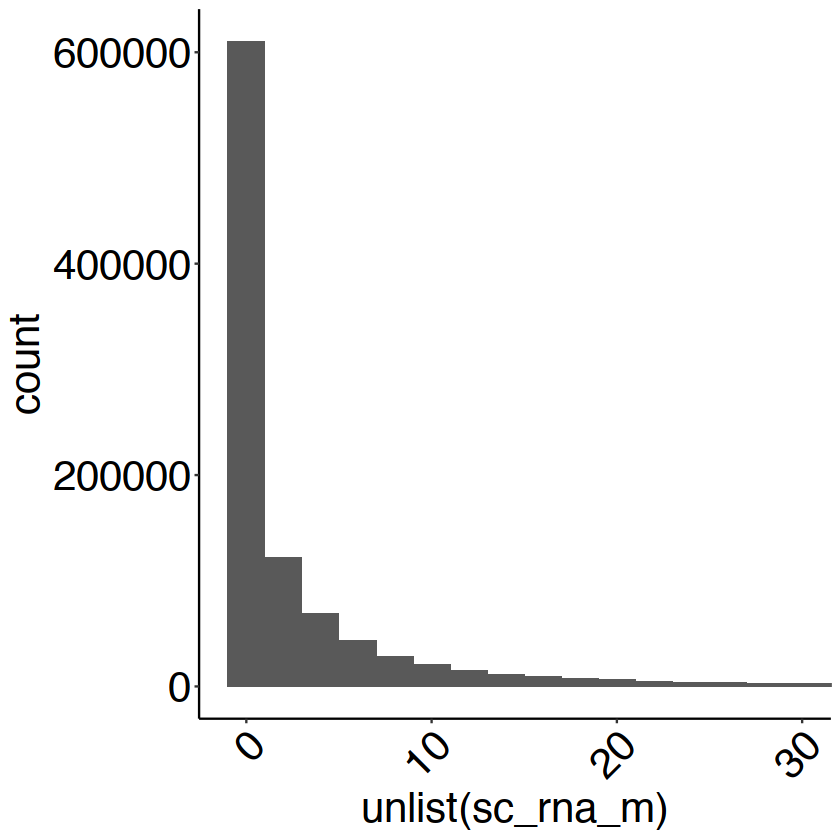

In [43]:
ggplot() + geom_histogram(aes(unlist(sc_rna_m)), binwidth = 2) + myaxis + myplot +
coord_cartesian(xlim = c(-1,30))

Choose genes expressed > 75th percentile in at least one dataset

In [44]:
sc_rna_genes <- rownames(sc_rna_m)[rowSums(sc_rna_m > quantile(unlist(sc_rna_m), 0.75)) >= 1]

In [45]:
length(sc_rna_genes)

[1] 15302

In [46]:
head(sc_rna)

,Alveolar.cells.type.1,Alveolar.cells.type.2,B.cells,Basal.glandular.cells,Basal.keratinocytes,Bipolar.cells,Cardiomyocytes,Cholangiocytes,Ciliated.cells,Club.cells,⋯,Rod.photoreceptor.cells,Sertoli.cells,Smooth.muscle.cells,Spermatocytes,Spermatogonia,Suprabasal.keratinocytes,Syncytiotrophoblasts,T.cells,Undifferentiated.cells,Urothelial.cells
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TSPAN6,3.0,8.5,7.8,36.0,6.4,0.7,7.3,61.1,115.1,21.6,⋯,1.5,19.4,7.5,19.0,32.2,4.6,11.3,3.5,78.3,78.2
TNMD,0.0,0.0,0.0,0.0,1.8,0.0,0.0,0.0,0.0,0.0,⋯,0.0,0.0,0.0,0.0,0.0,0.9,0.0,0.0,0.5,0.0
DPM1,17.9,40.2,52.1,126.5,103.5,11.0,36.2,20.4,77.6,43.3,⋯,10.2,71.1,61.3,110.0,113.4,92.2,205.3,55.3,48.2,127.0
SCYL3,6.0,11.8,5.2,1.7,2.2,9.6,3.4,22.9,2.7,9.1,⋯,17.6,6.5,4.1,7.2,6.4,1.6,9.7,10.2,9.9,2.3
C1orf112,0.0,3.5,2.2,2.6,1.5,3.8,0.4,0.0,2.7,1.2,⋯,6.5,6.5,1.2,27.7,17.7,0.9,3.2,1.9,1.6,1.4
FGR,6.0,30.7,12.5,0.5,2.5,0.0,1.6,2.5,2.7,10.3,⋯,0.0,0.0,1.0,0.2,0.5,1.0,0.8,45.8,0.0,0.9


In [47]:
# get mad/med scores for all genes across all celltypes
sc_rna_mcentr <- t(apply(sc_rna,1, mcentr))

colnames(sc_rna_mcentr) <- colnames(sc_rna)

In [48]:
head(sc_rna_mcentr)

,Alveolar.cells.type.1,Alveolar.cells.type.2,B.cells,Basal.glandular.cells,Basal.keratinocytes,Bipolar.cells,Cardiomyocytes,Cholangiocytes,Ciliated.cells,Club.cells,⋯,Rod.photoreceptor.cells,Sertoli.cells,Smooth.muscle.cells,Spermatocytes,Spermatogonia,Suprabasal.keratinocytes,Syncytiotrophoblasts,T.cells,Undifferentiated.cells,Urothelial.cells
TSPAN6,-0.7060459,-0.4891044,-0.5167151,0.5956030,-0.5719366,-0.7967669,-0.5364371,1.585645,3.7156158,0.02761073,⋯,-0.7652117,-0.05916586,-0.5285483,-0.07494342,0.44571612,-0.6429356,-0.3786615,-0.6863239,2.2640801,2.2601357
TNMD,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.0000000,0.00000000,⋯,0.0000000,0.00000000,0.0000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
DPM1,-1.3207306,-0.5332362,-0.1130037,2.5143320,1.7021180,-1.5643948,-0.6744908,-1.232446,0.7874944,-0.42376383,⋯,-1.5926457,0.55795571,0.2118819,1.93165678,2.05172320,1.3030738,5.2970478,0.0000000,-0.2507269,2.5319889
SCYL3,0.0000000,1.3489815,-0.1860664,-1.0001070,-0.8838155,0.8372989,-0.6047159,3.930653,-0.7675240,0.72100736,⋯,2.6979630,0.11629151,-0.4419077,0.27909962,0.09303321,-1.0233653,0.8605572,0.9768487,0.9070738,-0.8605572
C1orf112,-1.1933298,0.6226069,-0.0518839,0.1556517,-0.4150712,0.7782586,-0.9857942,-1.193330,0.2075356,-0.57072295,⋯,2.1791240,2.17912399,-0.5707230,13.17851176,7.99012130,-0.7263747,0.4669551,-0.2075356,-0.3631873,-0.4669551
FGR,7.4193984,40.7392419,16.1877782,0.0000000,2.6979630,-0.6744908,1.4838797,2.697963,2.9677593,13.22001889,⋯,-0.6744908,-0.67449076,0.6744908,-0.40469446,0.00000000,0.6744908,0.4046945,61.1088628,-0.6744908,0.5395926


In [49]:
# get a list of tables with differences in med/mad scores among cell types
diff_gen_list_sc <- mclapply(rownames(sc_rna_mcentr), function(x){
    mygen <- x
    gen_df <- sc_rna_mcentr[mygen,]
    #get m-score difference across cell types
    tab_diff <- outer(gen_df, gen_df, "-")
    #keep immune cells in rows and non-immune in cols    
    immunecells <- c("B.cells", "T.cells", "granulocytes","Macrophages", "monocytes")
    
    return(tab_diff[immunecells, !colnames(tab_diff) %in% immunecells])
})

names(diff_gen_list_sc) <- rownames(sc_rna_mcentr)

In [50]:
diff_gen_list_sc["NUB1"]

,Alveolar.cells.type.1,Alveolar.cells.type.2,Basal.glandular.cells,Basal.keratinocytes,Bipolar.cells,Cardiomyocytes,Cholangiocytes,Ciliated.cells,Club.cells,Collecting.duct.cells,⋯,Proximal.tubular.cells,Rod.photoreceptor.cells,Sertoli.cells,Smooth.muscle.cells,Spermatocytes,Spermatogonia,Suprabasal.keratinocytes,Syncytiotrophoblasts,Undifferentiated.cells,Urothelial.cells
B.cells,-1.56096433,-0.8415075,1.0085243,1.426066,0.5652875,-0.4817791,0.8736261,-1.8050657,-1.7665234,1.271897,⋯,0.8800498,0.2633726,1.181965,0.3533047,-3.327488,2.023472,1.214083,0.14774559,1.432490,0.8736261
T.cells,-1.31686291,-0.5974061,1.2526257,1.670168,0.8093889,-0.2376777,1.1177275,-1.5609643,-1.5224220,1.515998,⋯,1.1241513,0.5074740,1.426066,0.5974061,-3.083386,2.267574,1.458185,0.39184701,1.676591,1.1177275
granulocytes,0.05781349,0.7772703,2.6273021,3.044844,2.1840653,1.1369987,2.4924039,-0.1862879,-0.1477456,2.890675,⋯,2.4988277,1.8821504,2.800743,1.9720825,-1.708710,3.642250,2.832861,1.76652342,3.051268,2.4924039
Macrophages,-1.66374387,-0.9442871,0.9057447,1.323287,0.4625079,-0.5845587,0.7708466,-1.9078453,-1.8693030,1.169117,⋯,0.7772703,0.1605930,1.079185,0.2505251,-3.430267,1.920693,1.111304,0.04496605,1.329710,0.7708466
monocytes,55.37890321,56.0983600,57.9483918,58.365934,57.5051550,56.4580884,57.8134937,55.1348018,55.1733441,58.211764,⋯,57.8199174,57.2032401,58.121832,57.2931722,53.612380,58.963340,58.153951,57.08761314,58.372357,57.8134937


Select genes if any immune cells express >=2 m compared to all nonimmune cells

In [51]:
diff_gen_list_sc_immune <- lapply(diff_gen_list_sc, function(x) x[ rowSums(x >= 2) == 46,,drop = F])

In [52]:
# remove empty lists
diff_gen_list_sc_immune <- diff_gen_list_sc_immune[sapply(diff_gen_list_sc_immune, function(x) length(unlist(x))) >= 46]

In [53]:
length(diff_gen_list_sc_immune)

[1] 554

In [54]:
diff_gen_list_sc_immune_expressed <- diff_gen_list_sc_immune[names(diff_gen_list_sc_immune) %in% sc_rna_genes]

In [55]:
length(diff_gen_list_sc_immune_expressed)

[1] 535

In [56]:
pa_sc_genes <- names(diff_gen_list_sc_immune_expressed)

In [57]:
head(pa_sc_genes)

[1] "SNX11"   "ALS2"    "ITGAL"   "MAP3K14" "MATK"    "CD79B"

Selected 535 genes that are expressed more than 75th (of the entire dataset) in at least one cell type AND have >2 mad difference in expression between at least one immune celltype and all non-immune celltypes

## 3- protein atlas tissue specificity data

In [58]:
proteinatlas <- read.csv(paste0(datapath, "TME_clusters/proteinatlas_v20.1.csv"), header = TRUE, stringsAsFactors = FALSE)

In [59]:
#match genes from the immune cell compendium with the proteinatlas
gene_cells_tissuespecificity <- as.data.frame(proteinatlas$Gene)
gene_cells_tissuespecificity$tissue <- proteinatlas$RNA.tissue.specific.NX
colnames(gene_cells_tissuespecificity) <- c("Gene", "Tissue")

In [60]:
gene_cells_tissuespecificity <- gene_cells_tissuespecificity[gene_cells_tissuespecificity$Tissue != "",]

In [61]:
head(gene_cells_tissuespecificity)

,Gene,Tissue
,<chr>,<chr>
1,TSPAN6,salivary gland: 88.4
2,TNMD,adipose tissue: 18.4;seminal vesicle: 25.0
5,C1orf112,lymphoid tissue: 24.6
6,FGR,adipose tissue: 20.8;blood: 68.0;bone marrow: 73.6;lung: 30.9;lymphoid tissue: 54.3
7,CFH,liver: 295.2
9,GCLC,liver: 69.2


In [62]:
#separate rows
gene_cells_tissuespecificity_sep <- separate_rows(gene_cells_tissuespecificity, Tissue,sep = ";")

In [63]:
#seprate gene expression as a new column
gene_cells_tissuespecificity_sep$NX <- gsub(".*:", "", gene_cells_tissuespecificity_sep$Tissue)
gene_cells_tissuespecificity_sep$Tissue <- gsub(":.*", "", gene_cells_tissuespecificity_sep$Tissue)
gene_cells_tissuespecificity_sep$NX <- as.numeric(gene_cells_tissuespecificity_sep$NX)

In [64]:
# group some blood related tissues - keep others the same as tissue
gene_cells_tissuespecificity_sep$Tissuegroup <- NA
gene_cells_tissuespecificity_sep$Tissuegroup[ grepl("blood", gene_cells_tissuespecificity_sep$Tissue)] <- "Blood"
gene_cells_tissuespecificity_sep$Tissuegroup[ grepl("lymphoid", gene_cells_tissuespecificity_sep$Tissue)] <- "Blood"
gene_cells_tissuespecificity_sep$Tissuegroup[ grepl("marrow", gene_cells_tissuespecificity_sep$Tissue)] <- "Blood"
gene_cells_tissuespecificity_sep$Tissuegroup[ is.na(gene_cells_tissuespecificity_sep$Tissuegroup)] <- 
 gene_cells_tissuespecificity_sep$Tissue[ is.na(gene_cells_tissuespecificity_sep$Tissuegroup)]

In [65]:
table(gene_cells_tissuespecificity_sep$Tissuegroup)


   adipose tissue     adrenal gland             Blood             brain 
              212               228              3351              2587 
           breast   cervix, uterine   ductus deferens     endometrium 1 
              187               131               115                85 
       epididymis         esophagus    fallopian tube       gallbladder 
              412               311               312               161 
     heart muscle         intestine            kidney             liver 
              387               764               413               936 
             lung             ovary          pancreas parathyroid gland 
              239               173               422               224 
  pituitary gland          placenta          prostate            retina 
              353               494               120               310 
   salivary gland   seminal vesicle   skeletal muscle            skin 1 
              319               180               

In [66]:
head(gene_cells_tissuespecificity_sep,10)

Gene,Tissue,NX,Tissuegroup
<chr>,<chr>,<dbl>,<chr>
TSPAN6,salivary gland,88.4,salivary gland
TNMD,adipose tissue,18.4,adipose tissue
TNMD,seminal vesicle,25.0,seminal vesicle
C1orf112,lymphoid tissue,24.6,Blood
FGR,adipose tissue,20.8,adipose tissue
FGR,blood,68.0,Blood
FGR,bone marrow,73.6,Blood
FGR,lung,30.9,lung
FGR,lymphoid tissue,54.3,Blood


In [67]:
#rm genes if more than one tissuegroup
gene_cells_tissuespecificity_sep_specific <- gene_cells_tissuespecificity_sep[0,]

for(g in unique(gene_cells_tissuespecificity_sep$Gene)){
    tmp <- gene_cells_tissuespecificity_sep[ gene_cells_tissuespecificity_sep$Gene == g,]
    if(nrow(tmp) == 1){ 
    gene_cells_tissuespecificity_sep_specific <- rbind(gene_cells_tissuespecificity_sep_specific, tmp)
    } else{
    if(length(unique(tmp$Tissuegroup)) == 1){ 
    gene_cells_tissuespecificity_sep_specific <- rbind(gene_cells_tissuespecificity_sep_specific, tmp)
    }}
    
}

In [68]:
dim(gene_cells_tissuespecificity_sep)
dim(gene_cells_tissuespecificity_sep_specific)

[1] 18189     4

[1] 7206    4

In [69]:
# keep only blood related genes
blood_specific <- gene_cells_tissuespecificity_sep_specific[ gene_cells_tissuespecificity_sep_specific$Tissuegroup == "Blood",]

In [70]:
dim(blood_specific)

[1] 1791    4

In [71]:
pa_blood_genes <- blood_specific$Gene[!duplicated(blood_specific$Gene)]

In [72]:
head(pa_blood_genes)

[1] "C1orf112" "MCUB"     "MPO"      "ITGAL"    "ALDH3B1"  "CEACAM21"

In [73]:
length(pa_blood_genes)

[1] 1257

1257 genes are specific to blood related tissues according to pan-tissue analysis using protein atlas

## 4- ImmuneScore genes from ESTIMATE

In [74]:
# Yoshihara suppl data 1
estimate_sigs <- read.csv(file = paste0(datapath, "TME_clusters/ESTIMATE_genesig.csv"),
                          header = T, stringsAsFactors = F, check.names = F, skip = 1)

In [75]:
immunescore_genes <- estimate_sigs$Gene[ estimate_sigs$Set == "Immune141_UP"]

In [76]:
length(immunescore_genes)

[1] 141

141 genes are used in ESTIMATE ImmuneScore that we benchmarked

## Compile all immune genes

In [77]:
tmp <- c(compendium_immune_genes, pa_sc_genes, pa_blood_genes, immunescore_genes)

In [78]:
immune_genes <- tmp[!duplicated(tmp)]

In [79]:
length(immune_genes)

[1] 3041

# Filter out genes expressed in pediatric tumour/non-immune cells

## 1- PDX

In [80]:
pdx_mat1 <- read.table(paste0(datapath, "exp_mat/PDX_2017Oct06.normalizedTPMs_perGencodeV26Gene.sleuth.txt"), sep = "\t",
                             header = TRUE, check.names = F,
                             stringsAsFactors = FALSE)

In [81]:
head(pdx_mat1)

,sample,target_id,scaled_reads_per_base,tpm
,<chr>,<chr>,<dbl>,<dbl>
1,BT084_XP3_2,7SK,0.0000000,0.00000000
2,BT084_XP5_845,7SK,0.0000000,0.00000000
3,Icb_984MB_XP11,7SK,0.0000000,0.00000000
4,Med113FH_P0-4,7SK,0.6526691,0.05560582
5,Med113FH_P5-2,7SK,0.6021602,0.04985232
6,Med114FH_P5-3,7SK,0.0000000,0.00000000


In [82]:
pdx_mat1$scaled_reads_per_base <- NULL
pdx_mat_tpm <- longtowidefx(pdx_mat1)
rownames(pdx_mat_tpm) <- pdx_mat_tpm$target_id
pdx_mat_tpm$target_id <- NULL

In [83]:
dim(pdx_mat_tpm)

[1] 51472    20

In [84]:
pdx_mat <- read.table(paste0(datapath, "exp_mat/RNAseq_itcc-P4_TPM_values_210726.tsv"), sep = "\t",
                      header = TRUE, check.names = F, comment.char = "", stringsAsFactors = FALSE)

In [85]:
pdx_mat[1:10,1:10]

,#chrom,chromStart,chromEnd,gene_id,score,strand,name,exonic_length,ITCC-P4_s01_EP0027_TP01_F01_R01_A03,ITCC-P4_s01_EP0027_PP01_F01_R01_A03
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
1,1,11869,14412,ENSG00000223972.4,.,+,DDX11L1,1756,0.00000000,0.00000000
2,1,14363,29806,ENSG00000227232.4,.,-,WASH7P,2073,88.16388486,124.73545549
3,1,29554,31109,ENSG00000243485.2,.,+,MIR1302-11,1021,0.18749550,0.03864177
4,1,34554,36081,ENSG00000237613.2,.,-,FAM138A,1219,0.00000000,0.00000000
5,1,52473,54936,ENSG00000268020.2,.,+,OR4G4P,947,0.00000000,0.00000000
6,1,62948,63887,ENSG00000240361.1,.,+,OR4G11P,940,0.00000000,0.00000000
7,1,69091,70008,ENSG00000186092.4,.,+,OR4F5,918,0.00000000,0.00000000
8,1,89295,133566,ENSG00000238009.2,.,-,RP11-34P13.7,3569,0.14558801,0.09948984
9,1,89551,91105,ENSG00000239945.1,.,-,RP11-34P13.8,1319,0.00000000,0.00000000


In [86]:
dim(pdx_mat)

[1] 57820   175

In [87]:
# dedup
pdx_mat <- pdx_mat[!duplicated(pdx_mat$name),]

In [88]:
dim(pdx_mat)

[1] 55765   175

In [89]:
rownames(pdx_mat) <- pdx_mat$name

In [90]:
pdx_mat <- pdx_mat[, grepl("ITCC",colnames(pdx_mat))]

In [91]:
# include only CNS and NBL pdxes, remove all others

pdx_mat <- pdx_mat[,grep(paste(c("EP", "MB", "HG", "NB", "RT"),collapse="|"),colnames(pdx_mat), value=TRUE)]
pdx_mat <- pdx_mat[,grep(paste(c("PP", "PT", "PR", "PM"),collapse="|"),colnames(pdx_mat), value=TRUE)]
pdx_mat <- pdx_mat[,!colnames(pdx_mat) %in% c("ITCC.P4_s07_HG0068_PT01_F01_R01_A03","ITCC.P4_s15_NB0537_PT03_F01_R01_03")]

In [92]:
#match rownames and bind both pdx matrices
pdx_mat <- pdx_mat[rownames(pdx_mat_tpm),]
pdx_mat <- cbind(pdx_mat, pdx_mat_tpm)

In [93]:
dim(pdx_mat)

[1] 51472    81

Subset to protein_coding genes

In [94]:
hg38 <- useMart(biomart="ENSEMBL_MART_ENSEMBL", host="www.ensembl.org", 
                path="/biomart/martservice", dataset="hsapiens_gene_ensembl")

In [95]:
hgncs <- rownames(pdx_mat)

In [96]:
hgnc_type <- getBM(filters="hgnc_symbol",
                   attributes=c("hgnc_symbol","ensembl_gene_id", "entrezgene_id", "gene_biotype"), 
                   values= hgncs,mart = hg38)

In [97]:
table(hgnc_type$gene_biotype)


                         IG_C_gene                    IG_C_pseudogene 
                                23                                 10 
                         IG_D_gene                          IG_J_gene 
                                64                                 24 
                   IG_J_pseudogene                          IG_V_gene 
                                 6                                207 
                   IG_V_pseudogene                             lncRNA 
                               274                               1699 
                             miRNA                           misc_RNA 
                                 9                               1021 
            polymorphic_pseudogene               processed_pseudogene 
                                61                               4138 
                    protein_coding                           ribozyme 
                             20558                                  5 
     

In [98]:
proteincoding <- hgnc_type$hgnc_symbol[hgnc_type$gene_biotype == "protein_coding"]

In [99]:
pdx_mat_tpm_pc <- pdx_mat[proteincoding,]

In [100]:
dim(pdx_mat)
dim(pdx_mat_tpm_pc)

[1] 51472    81

[1] 20558    81

In [101]:
#median center MAD scale
pdx_mat_tpm_m <- (pdx_mat_tpm_pc - median(unlist(pdx_mat_tpm_pc)))/mad(unlist(pdx_mat_tpm_pc))

In [102]:
summary(unlist(pdx_mat_tpm_pc))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
     0.00      0.17      8.07     60.79     38.12 211758.04 

In [103]:
summary(unlist(pdx_mat_tpm_m))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
   -0.674    -0.660     0.000     4.407     2.512 17702.256 

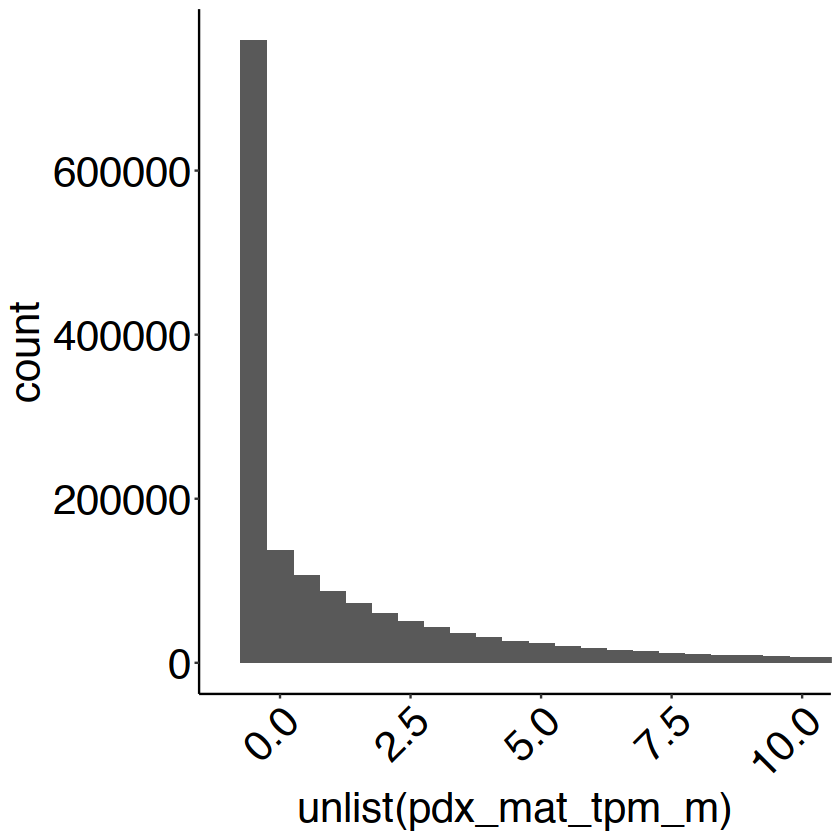

In [104]:
ggplot() + geom_histogram(aes(unlist(pdx_mat_tpm_m)), binwidth = 0.5) + myaxis + myplot +
coord_cartesian(xlim = c(-1,10))

In [105]:
head(pdx_mat_tpm_m)

,ITCC-P4_s01_EP0027_PP01_F01_R01_A03,ITCC-P4_s01_EP0035_PP01_F01_R01_A03,ITCC-P4_s01_EP0076_PR03_F01_R01_A03,ITCC-P4_s01_EP0076_PP03_F01_R01_A03,ITCC-P4_s01_EP0077_PP02_F01_R01,ITCC-P4_s01_EP0191_PR01_F01_R01_A03,ITCC-P4_s05_EP0191_PR04_F01_R01_03,ITCC-P4_s01_EP0233_PR01_F01_R01_A03,ITCC-P4_s05_EP0233_PR05_F01_R01_03,ITCC-P4_s01_EP0307_PM01_F01_R01_A03,⋯,Med210FH_fP5_5043,Med2312FH_P5-2,Med411FH_P5-4,Med610FH_P4-2,Med813FH_P5-2,Med913FH_P1-2+3,NCH2194_XP1_1020,NCH2194_XP6_686,Neo113FH_P5-5,RCMB28_XP5_283
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,-0.5921572,-0.5836629,-0.3548150,-0.4901875,-0.6674572,-0.4697676,-0.44166461,-0.5083461,-0.59639219,-0.6714543,⋯,1.2647239,0.7400879,2.5806388,0.04548172,2.4076761,0.1735341,3.9535341,0.7499960,0.7800400,1.2543403
A1CF,-0.6703692,-0.6728313,-0.6683359,-0.6712191,-0.6686225,-0.6592403,-0.66322977,-0.6633119,-0.66750939,-0.6668906,⋯,-0.6728263,-0.6728055,-0.6743808,-0.67449076,-0.6738131,-0.6730773,-0.6739310,-0.6743220,-0.6729747,-0.6732867
A2M,-0.2870044,-0.4868648,-0.6035097,-0.6297066,-0.6391818,0.3325836,-0.05303696,-0.6005020,0.30565609,-0.6459099,⋯,-0.6741509,-0.6744908,-0.6744908,-0.58097049,-0.6741266,-0.6744908,-0.6737666,-0.6744908,-0.6722639,-0.6744908
A2ML1,2.0208616,-0.3802814,4.0911310,3.9687056,-0.6455542,1.0240346,4.36376765,0.5808520,0.60153885,-0.5862131,⋯,-0.6471392,-0.6534215,-0.6701000,-0.66495081,-0.6555912,-0.6400824,-0.6497869,-0.6558138,-0.6434327,-0.6281294
A3GALT2,-0.5838270,-0.6644211,-0.5064180,-0.5732390,-0.5676603,-0.5495570,-0.52714454,-0.5930872,-0.56857916,-0.5822519,⋯,-0.6659630,-0.6664484,-0.6685383,-0.64757426,-0.6261245,-0.6276556,-0.6431204,-0.6059228,-0.6307213,-0.6505268
A4GALT,0.6300293,-0.4416608,0.2560422,0.2638807,0.2589825,-0.1768687,-0.09806009,-0.0252056,-0.02905257,-0.5670277,⋯,-0.6691560,-0.6706098,-0.6712372,-0.67058317,3.0426267,-0.6298772,-0.6744908,-0.6744908,-0.6576712,-0.6740484


In [106]:
dim(pdx_mat_tpm_m)

[1] 20558    81

In [107]:
pdx_expressed_genes <- rownames(pdx_mat_tpm_m)[rowSums(pdx_mat_tpm_m > quantile(unlist(pdx_mat_tpm_m),0.75)) >= 1]

In [108]:
length(pdx_expressed_genes)

[1] 13788

13788 protein coding genes are expressed more than 75th percentile in at least one PDX 

## 2- scRNA

### 1- Frank's NBL

In [109]:
load(file = paste0(datapath, "single_cell/NBL_original_annotation/NBL_tumor_cells.RData"))

In [110]:
nbl_tum <- as.matrix(nbl_tum)

In [111]:
nbl_immune <- read.table(paste0(datapath, "single_cell/NBL_original_annotation/NBL_immune_cells.txt"), sep = "\t",
                         header = TRUE, check.names = F,stringsAsFactors = FALSE)

nbl_immune <- as.matrix(nbl_immune)

In [112]:
nbl_endo <- read.table(paste0(datapath, "single_cell/NBL_original_annotation/NBL_endothelial_cells.txt"), sep = "\t",
                             header = TRUE, check.names = F,stringsAsFactors = FALSE)

nbl_endo <- as.matrix(nbl_endo)

In [113]:
nbl_mesench <- read.table(paste0(datapath, "single_cell/NBL_original_annotation/NBL_mesenchymal_cells.txt"), sep = "\t",
                             header = TRUE, check.names = F,stringsAsFactors = FALSE)

nbl_mesench <- as.matrix(nbl_mesench)

In [114]:
nbl_schwann <- read.table(paste0(datapath, "single_cell/NBL_original_annotation/NBL_schwann_cells.txt"), sep = "\t",
                             header = TRUE, check.names = F,stringsAsFactors = FALSE)

nbl_schwann <- as.matrix(nbl_schwann)

In [115]:
dim(nbl_immune)

[1] 26344  2407

In [116]:
# Get max counts for each cell annotation
maxcount_tumor <- apply(nbl_tum, 1, max)
maxcount_immune <- apply(nbl_immune, 1, max)
maxcount_endo <- apply(nbl_endo, 1, max)
maxcount_mesench <- apply(nbl_mesench, 1, max)
maxcount_schwann <- apply(nbl_schwann, 1, max)

In [117]:
nbl <- cbind.data.frame(maxcount_tumor, maxcount_immune, maxcount_endo, maxcount_mesench, maxcount_schwann)

In [118]:
head(nbl)

,maxcount_tumor,maxcount_immune,maxcount_endo,maxcount_mesench,maxcount_schwann
,<int>,<int>,<int>,<int>,<int>
RP11-34P13.7,2,1,1,0,1
AL627309.1,2,3,0,1,0
AP006222.2,4,2,1,1,1
RP4-669L17.10,4,2,2,3,1
RP5-857K21.4,6,2,1,2,1
RP11-206L10.5,1,1,1,0,0


In [119]:
mad(unlist(nbl))

[1] 1.4826

In [120]:
nbl_m <- (nbl - median(unlist(nbl)))/ mad(unlist(nbl))

In [121]:
summary(unlist(nbl_m))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
  -0.6745    0.0000    0.0000    0.7823    0.6745 1607.9860 

In [122]:
summary(unlist(nbl))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    1.00    1.00    2.16    2.00 2385.00 

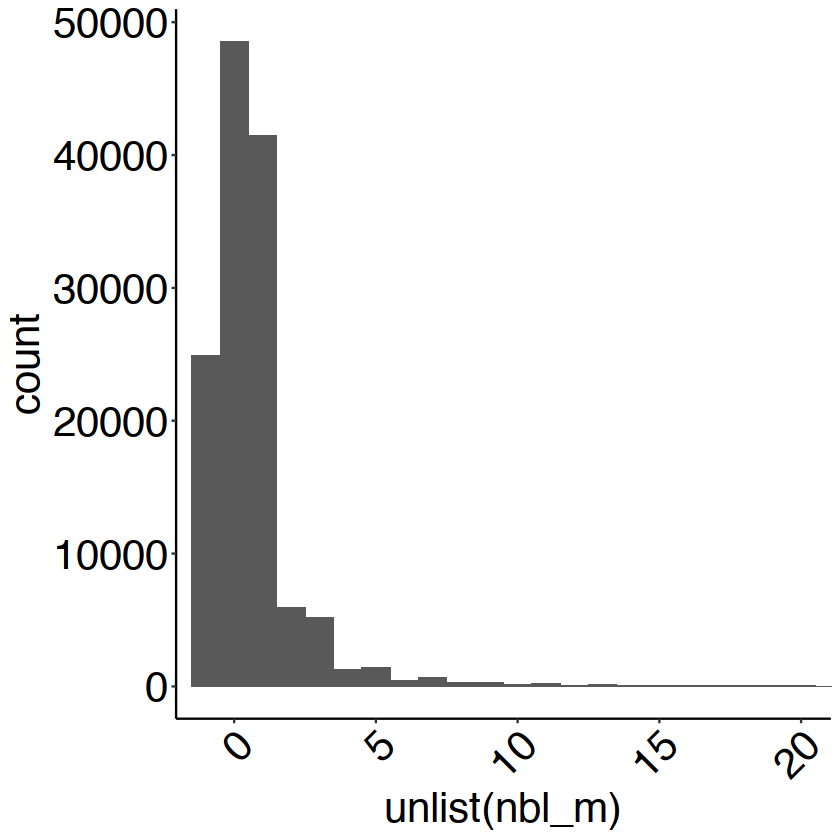

In [123]:
ggplot() + geom_histogram(aes(unlist(nbl_m)), binwidth = 1) + myaxis + myplot  +
coord_cartesian(xlim = c(-1,20))

In [124]:
nbl_expressed_genes <- rownames(nbl_m)[rowSums(nbl_m > quantile(unlist(nbl), 0.75)) >= 1]

In [125]:
length(nbl_expressed_genes)

[1] 8825

In [126]:
dim(nbl_m)

[1] 26344     5

In [127]:
# median center genes across cell types.
nbl_mcentr <- t(apply(nbl,1,mcentr))
colnames(nbl_mcentr) <- colnames(nbl)

In [128]:
# get a list of tables of differences for each gene
diff_gen_list_nbl <- mclapply(rownames(nbl_mcentr), function(x){
    mygen <- x
    gen_df <- nbl_mcentr[mygen,]
    #get ratio differences in counts across cell types
    gen_tab_ratio <- outer(gen_df, gen_df, "-")
    
    return(gen_tab_ratio[c("maxcount_tumor", "maxcount_endo",
                          "maxcount_mesench", "maxcount_schwann"), "maxcount_immune", drop = F])    
})

names(diff_gen_list_nbl) <- rownames(nbl_mcentr)

In [129]:
#genes with score diff > 2 in nonimmune vs immune
diff_gen_list_nbl_nonimmune <- lapply(diff_gen_list_nbl, function(x) x[ rowSums(x >= 2) == 1,, drop = F])

In [130]:
# rmeove empty lists
diff_gen_list_nbl_nonimmune <- diff_gen_list_nbl_nonimmune[sapply(diff_gen_list_nbl_nonimmune, function(x) length(unlist(x)) >= 1)]

In [131]:
tail(diff_gen_list_nbl_nonimmune)

,maxcount_immune
maxcount_mesench,2.023472
,maxcount_immune
maxcount_tumor,2.023472
,maxcount_immune
maxcount_mesench,2.023472
,maxcount_immune
maxcount_endo,2.023472
maxcount_mesench,2.023472
,maxcount_immune
maxcount_tumor,10.79185


In [132]:
# select genes with score (of expression across all celltypes) > 0
nbl_nonimmune_genes_expressed <- diff_gen_list_nbl_nonimmune[names(diff_gen_list_nbl_nonimmune) %in% 
                                                             nbl_expressed_genes]

In [133]:
length(diff_gen_list_nbl_nonimmune)
length(nbl_nonimmune_genes_expressed)

[1] 3054

[1] 3036

In [134]:
nbl_nonimmune_genes_expressed <- names(nbl_nonimmune_genes_expressed)

In [135]:
length(nbl_nonimmune_genes_expressed)

[1] 3036

In [136]:
nbl_nonimmune_genes_expressed[ nbl_nonimmune_genes_expressed == "CD8A"]

character(0)

3036 genes are expressed > 75th percentile expression of all genes in at least one cell type AND are expressed >2 difference in at least one nonimmune celltype compared to immune celltype

### 2- Gojo's EPN

In [137]:
gojo_files <- list.files(paste0(datapath,"single_cell/"), pattern = "gojo", full.names = T, recursive = T)

In [138]:
gojofiles <- lapply(gojo_files, 
                    function(f){read.table(f, header = TRUE, sep = "\t", stringsAsFactors = F)})

In [139]:
names(gojofiles) <- gsub(".*gojo", "gojo", gojo_files)

In [140]:
#bind all tumour clusters together
gojofiles_tum <- as.data.frame(do.call("cbind", gojofiles[5:25]))

In [141]:
dim(gojofiles_tum)

[1] 23686  5426

In [142]:
gojo_data <- list()

gojo_data$Tumor <- gojofiles_tum
gojo_data$Endothelial <- gojofiles[["gojo_Endothelial-cell.txt"]]
gojo_data$Microglia <- gojofiles[["gojo_Microglia.txt"]]
gojo_data$Oligodend <- gojofiles[["gojo_Oligodendrocyte.txt"]]
gojo_data$OPC <- gojofiles[["gojo_OPC.txt"]]
gojo_data$T_cells <- gojofiles[["gojo_T-cell.txt"]]

In [143]:
gojo_maxcounts <- lapply(gojo_data, function(x){apply(x, 1, max)})

In [144]:
gojo_maxcounts_all <- as.data.frame(do.call("cbind", gojo_maxcounts))

In [145]:
tail(gojo_maxcounts_all)

,Tumor,Endothelial,Microglia,Oligodend,OPC,T_cells
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZXDC,809.50,562.61,336.66,162.93,481.09,91.02
ZYG11A,164.97,15.78,29.18,6.85,11.17,11.00
ZYG11B,1786.92,139.13,130.99,187.98,339.48,47.00
ZYX,880.00,298.00,714.00,97.00,1156.00,142.00
ZZEF1,893.99,335.00,631.02,292.00,178.00,369.00
ZZZ3,2244.02,403.00,128.00,256.00,286.00,131.00


In [146]:
mean(unlist(gojo_maxcounts_all))

[1] 259.5086

In [147]:
mad(unlist(gojo_maxcounts_all))

[1] 75.6126

In [148]:
gojo_maxcounts_m <- (gojo_maxcounts_all - median(unlist(gojo_maxcounts_all)))/ mad(unlist(gojo_maxcounts_all))

In [149]:
summary(unlist(gojo_maxcounts_m))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  -0.674   -0.661    0.000    2.758    2.156 3213.472 

In [150]:
head(gojo_maxcounts_m)

,Tumor,Endothelial,Microglia,Oligodend,OPC,T_cells
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,1.6531636,-0.1587037,-0.42320989,-0.4232099,-0.58191360,-0.22483025
A1BG-AS1,3.3274877,-0.3835340,-0.03147624,0.3437258,0.01177053,-0.16663889
A1CF,0.3570833,-0.5951389,-0.64804014,-0.6612655,-0.62158952,-0.66126545
A2M,143.5144407,377.1532787,82.76490955,-0.4496605,2.22185191,0.05290124
A2M-AS1,4.2850001,0.3570833,0.96544756,-0.5951389,-0.26450618,-0.67449076
A2ML1,7.2474693,-0.6083642,-0.64804014,-0.6480401,-0.63481483,-0.58191360


In [151]:
summary(unlist(gojo_maxcounts_all))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
     0.0      1.0     51.0    259.5    214.0 243030.0 

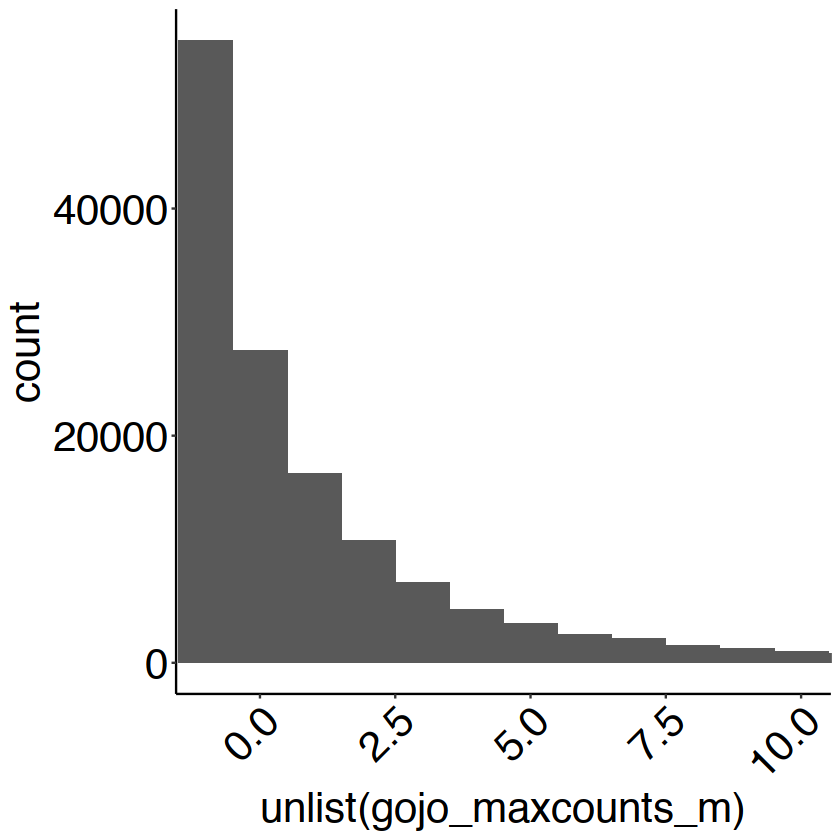

In [152]:
ggplot() + geom_histogram(aes(unlist(gojo_maxcounts_m)), binwidth = 1) + myplot + myaxis +
coord_cartesian(xlim = c(-1,10))

In [153]:
gojo_expressed_genes <- rownames(gojo_maxcounts_m)[rowSums(gojo_maxcounts_m > quantile(unlist(gojo_maxcounts_m), 0.75)) >= 1]

In [154]:
#median center genes
gojo_mcentr <- t(apply(gojo_maxcounts_all,1,mcentr))

colnames(gojo_mcentr) <- colnames(gojo_maxcounts_all)

In [155]:
head(gojo_mcentr)

,Tumor,Endothelial,Microglia,Oligodend,OPC,T_cells
A1BG,10.083637,0.8431134,-0.50586807,-0.5058681,-1.31525698,0.5058681
A1BG-AS1,8.821165,-0.9877034,-0.05715431,0.9345691,0.05715431,-0.4144124
A1CF,25.293403,1.0117361,-0.33724538,-0.6744908,0.33724538,-0.6744908
A2M,1.596040,5.2873202,0.63625332,-0.6784608,-0.63625332,-0.6705208
A2M-AS1,4.197559,0.3077773,0.91023510,-0.6352000,-0.30777734,-0.7137815
A2ML1,200.661001,0.3372454,-0.67449076,-0.6744908,-0.33724538,1.0117361


In [156]:
# get a list of tables with score differences for each gene
diff_gen_list_gojo <- mclapply(rownames(gojo_mcentr), function(x){
    mygen <- x
    gen_df <- gojo_mcentr[mygen,]
    #get differences in counts across cell types
    gen_tab_ratio <- outer(gen_df, gen_df, "-")
    
    return(gen_tab_ratio[c("Tumor", "Endothelial",
                          "Oligodend", "OPC"), c("Microglia", "T_cells"), drop = F])    
})

names(diff_gen_list_gojo) <- rownames(gojo_mcentr)

In [157]:
#genes with z score diff > 2 in nonimmune vs immune
diff_gen_list_gojo_nonimmune <- lapply(diff_gen_list_gojo, function(x) x[ rowSums(x >= 2) >= 1,, drop = F])

In [158]:
# rmeove empty lists
diff_gen_list_gojo_nonimmune <- diff_gen_list_gojo_nonimmune[sapply(diff_gen_list_gojo_nonimmune, 
                                                                  function(x) length(unlist(x)) >= 1)]

In [159]:
head(diff_gen_list_gojo_nonimmune)

,Microglia,T_cells
Tumor,10.5895,9.577769
,Microglia,T_cells
Tumor,8.878319,9.235577
,Microglia,T_cells
Tumor,25.63065,25.96789
,Microglia,T_cells
Tumor,0.959787,2.266561
Endothelial,4.651067,5.957841
,Microglia,T_cells
Tumor,3.287324,4.91134


In [160]:
length(diff_gen_list_gojo_nonimmune)

[1] 16573

In [161]:
# select expressed genes

gojo_nonimmune_genes_expressed <- diff_gen_list_gojo_nonimmune[names(diff_gen_list_gojo_nonimmune) %in% gojo_expressed_genes]

In [162]:
head(gojo_expressed_genes)

[1] "A1BG-AS1" "A2M"      "A2M-AS1"  "A2ML1"    "A4GALT"   "AAAS"

In [163]:
length(diff_gen_list_gojo_nonimmune)
length(gojo_nonimmune_genes_expressed)

[1] 16573

[1] 12109

In [164]:
gojo_nonimmune_genes_expressed <- names(gojo_nonimmune_genes_expressed)

12109 genes are expressed > 75th percentile in at least one cell type AND their expression is >2 mad differnet in at least one nonimmune and at least one immune

### 3- Gillen's EPN

In [165]:
gillen_files <- list.files(paste0(datapath,"single_cell/"), pattern = "gillen", full.names = T, recursive = T)

In [166]:
# remove doublet file
gillen_files <- gillen_files[!grepl("Doublets", gillen_files)]

In [167]:
gillenfiles <- lapply(gillen_files, 
                    function(f){read.table(f, header = TRUE, sep = "\t", stringsAsFactors = F)})

In [168]:
names(gillenfiles) <- gsub(".*gillen", "gillen", gillen_files)

In [169]:
names(gillenfiles)

[1] "gillen_1.txt"                "gillen_10.txt"              
 [3] "gillen_11.txt"               "gillen_12.txt"              
 [5] "gillen_13.txt"               "gillen_14.txt"              
 [7] "gillen_15.txt"               "gillen_2.txt"               
 [9] "gillen_3.txt"                "gillen_4.txt"               
[11] "gillen_5.txt"                "gillen_6.txt"               
[13] "gillen_7.txt"                "gillen_8.txt"               
[15] "gillen_9.txt"                "gillen_Lymphocytes.txt"     
[17] "gillen_Myeloid.txt"          "gillen_Oligodendrocytes.txt"

In [170]:
#bind all tumour clusters together
gillenfiles_tum <- as.data.frame(do.call("cbind", gillenfiles[1:15]))

In [171]:
dim(gillenfiles_tum)

[1] 23580 11200

In [172]:
gillen_data <- list()
gillen_data$Tumor <- gillenfiles_tum
gillen_data$Lymphocytes <- gillenfiles[["gillen_Lymphocytes.txt"]]
gillen_data$Myeloid <- gillenfiles[["gillen_Myeloid.txt"]]
gillen_data$Oligodend <- gillenfiles[["gillen_Oligodendrocytes.txt"]]

In [173]:
lapply(gillen_data, dim)

$Tumor
[1] 23580 11200

$Lymphocytes
[1] 23580  1675

$Myeloid
[1] 23580  5097

$Oligodend
[1] 23580   484

In [174]:
gillen_maxcounts <- lapply(gillen_data, function(x){apply(x, 1, max)})

In [175]:
gillen_maxcounts_all <- as.data.frame(do.call("cbind", gillen_maxcounts))

In [176]:
head(gillen_maxcounts_all)

,Tumor,Lymphocytes,Myeloid,Oligodend
,<int>,<int>,<int>,<int>
AL627309.1,2,1,1,1
AL669831.5,2,1,2,1
FAM87B,2,1,1,1
LINC00115,3,2,2,1
FAM41C,2,1,2,1
AL645608.3,2,1,1,1


In [177]:
gillen_maxcounts_m <- (gillen_maxcounts_all - median(unlist(gillen_maxcounts_all)))/mad(unlist(gillen_maxcounts_all))

In [178]:
summary(unlist(gillen_maxcounts_all))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
    0.000     1.000     2.000     7.536     5.000 23355.000 

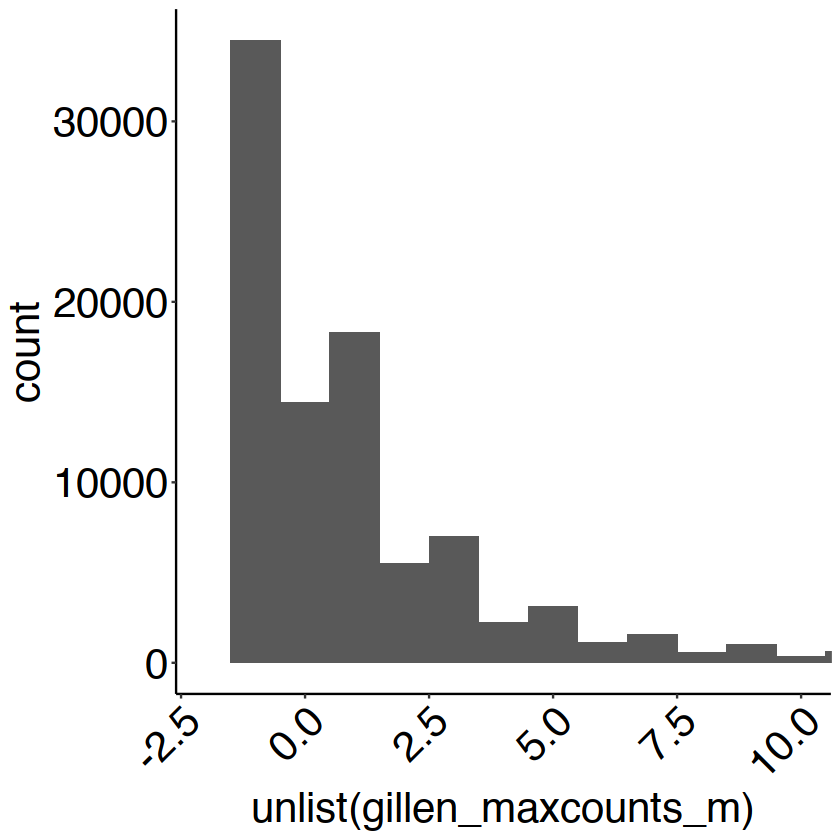

In [179]:
ggplot() + geom_histogram(aes(unlist(gillen_maxcounts_m)), binwidth = 1) + myaxis + myplot +
coord_cartesian(xlim = c(-2,10))

In [180]:
dim(gillen_maxcounts_m)

[1] 23580     4

In [181]:
gillen_expressed_genes <- rownames(gillen_maxcounts_m)[rowSums(gillen_maxcounts_m >= quantile(unlist(gillen_maxcounts_m), 0.75)) >= 1]

In [182]:
length(gillen_expressed_genes)

[1] 11649

In [183]:
# median center
gillen_mcentr <- t(apply(gillen_maxcounts_all,1,mcentr))

colnames(gillen_mcentr) <- colnames(gillen_maxcounts_all)

In [184]:
head(gillen_mcentr)

,Tumor,Lymphocytes,Myeloid,Oligodend
AL627309.1,0.0000000,0.0000000,0.0000000,0.0000000
AL669831.5,0.6744908,-0.6744908,0.6744908,-0.6744908
FAM87B,0.0000000,0.0000000,0.0000000,0.0000000
LINC00115,1.3489815,0.0000000,0.0000000,-1.3489815
FAM41C,0.6744908,-0.6744908,0.6744908,-0.6744908
AL645608.3,0.0000000,0.0000000,0.0000000,0.0000000


In [185]:
# get a list of tables with score differences 
diff_gen_list_gillen <- mclapply(rownames(gillen_mcentr), function(x){
    mygen <- x
    gen_df <- gillen_mcentr[mygen,]
    #get ratio differences in counts across cell types
    gen_tab_ratio <- outer(gen_df, gen_df, "-")
    
    return(gen_tab_ratio[c("Tumor", "Oligodend"), c("Myeloid", "Lymphocytes"), drop = F])    
})

names(diff_gen_list_gillen) <- rownames(gillen_mcentr)

In [186]:
#genes with z score diff > 2 in nonimmune vs immune
diff_gen_list_gillen_nonimmune <- lapply(diff_gen_list_gillen, function(x) x[ rowSums(x >= 2) >= 1,, drop = F])

In [187]:
# rmeove empty lists
diff_gen_list_gillen_nonimmune <- diff_gen_list_gillen_nonimmune[sapply(diff_gen_list_gillen_nonimmune, 
                                                                  function(x) length(unlist(x)) >= 1)]

In [188]:
head(diff_gen_list_gillen_nonimmune)

,Myeloid,Lymphocytes
Tumor,2.023472,2.023472
,Myeloid,Lymphocytes
Tumor,2.023472,3.372454
,Myeloid,Lymphocytes
Tumor,2.151079,1.203146
,Myeloid,Lymphocytes
Tumor,17.15134,17.15134
,Myeloid,Lymphocytes
Tumor,6.744908,0.000000
Oligodend,5.395926,-1.348982


In [189]:
# select genes with score (of median expression across all celltypes) > 0 
gillen_nonimmune_genes_expressed <- diff_gen_list_gillen_nonimmune[names(diff_gen_list_gillen_nonimmune) %in%
                                                                   gillen_expressed_genes]

In [190]:
length(diff_gen_list_gillen_nonimmune)
length(gillen_nonimmune_genes_expressed)

[1] 7961

[1] 5040

In [191]:
gillen_nonimmune_genes_expressed <- names(gillen_nonimmune_genes_expressed)

5040 genes are expressed > 75th percentile in at least one cell type AND their expression is >2 mad differnet in at least one nonimmune and at least one immune

## 3- Cell lines from CBTN

In [192]:
CBTN_RNA_manifest_genes <- read.csv(paste0(manifestpath, "CBTTC_RSEM-manifest.csv"), header = TRUE, stringsAsFactors = FALSE)

In [193]:
CBTN_celllines <- read.csv(paste0(manifestpath,"cell_line_RNAalqids_CBTTC.csv"), 
                             header = TRUE, stringsAsFactors = F)

CBTN_celllines$X <- NULL

In [194]:
dim(CBTN_celllines)

[1] 33  4

In [195]:
head(CBTN_celllines)

,case_id,patient_id,clinical_event,cell_lines_rnaalq_id
,<chr>,<chr>,<chr>,<chr>
1,C216603,PT_4347ZBEX,7316-913,739931
2,C22878,PT_TGQY3X3W,7316-24,739935
3,C28290,PT_3AWKWXEV,7316-85,740005
4,C337143,PT_C2D4JXS1,7316-1746,739942
5,C377856,PT_Z4PJA6KT,7316-1763,739939
6,C56826,PT_Y5KY6KN9,7316-195,739937


In [196]:
celllines_manifest <- CBTN_RNA_manifest_genes[CBTN_RNA_manifest_genes$aliquot_id %in% CBTN_celllines$cell_lines_rnaalq_id,]

In [197]:
dim(celllines_manifest)

[1] 22 20

In [198]:
table(celllines_manifest$disease_type)


                                      Ependymoma 
                                               1 
High-grade glioma/astrocytoma (WHO grade III/IV) 
                                              18 
                                 Medulloblastoma 
                                               3 

find cell line files using KF_CBTTC_tpm_rsem.txt file from cavatica (before colname cleanup)


In [199]:
CBTN_tpm_all <- read.table(paste0(datapath,"exp_mat/KF_CBTTC_tpm_rsem_matrix.txt"), sep = "\t", check.names = F,
                             header = TRUE, stringsAsFactors = F)

In [200]:
# some cleanup
colnames(CBTN_tpm_all) <- gsub(".*_RSEM/", "", colnames(CBTN_tpm_all))

In [201]:
CBTN_tpm_all[1:10,1:10]

,,00245bb9-b207-4648-b26e-bf16ec38103a.rsem.genes.results,0071cbef-6d2d-4328-b95b-f1076b66851a.rsem.genes.results,0080e250-aef6-4501-8f0e-42b483252440.rsem.genes.results,00a72866-565d-4e01-a666-e13ea722e7e3.rsem.genes.results,00d202e7-8c8b-4696-9d4b-8221e6251421.rsem.genes.results,00d8fca5-287f-40bb-a2bc-56bfd41fdccc.rsem.genes.results,010d6dff-c341-4d11-aa68-433e06bda14c.rsem.genes.results,01a28736-f93b-4e46-be14-dc604b48bf23.rsem.genes.results,01a81e81-dc1b-4387-997b-c9f956d9ac8f.rsem.genes.results
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000000003.14_TSPAN6,10.99,8.66,6.15,2.40,0.73,1.50,1.88,29.41,4.62
2,ENSG00000000005.5_TNMD,0.18,0.02,0.03,0.02,0.02,0.01,0.03,0.33,0.03
3,ENSG00000000419.12_DPM1,4.95,6.15,5.09,3.35,1.09,3.68,3.27,4.89,4.75
4,ENSG00000000457.13_SCYL3,1.50,1.75,1.71,0.90,0.44,1.44,0.89,1.52,1.61
5,ENSG00000000460.16_C1orf112,1.70,1.12,2.78,0.34,0.43,0.71,0.57,1.00,1.64
6,ENSG00000000938.12_FGR,1.27,0.90,0.18,1.12,0.36,1.32,1.05,0.93,1.01
7,ENSG00000000971.15_CFH,2.04,5.77,2.02,7.50,5.57,1.02,13.23,2.75,2.32
8,ENSG00000001036.13_FUCA2,7.86,7.15,3.33,4.47,1.40,1.88,8.94,10.26,5.99
9,ENSG00000001084.10_GCLC,14.26,13.19,7.39,11.16,1.20,15.90,3.18,16.94,8.09


In [202]:
CBTN_tpm_lines <- CBTN_tpm_all[, colnames(CBTN_tpm_all) %in% celllines_manifest$name]

In [203]:
dim(CBTN_tpm_lines)

[1] 58347    22

In [204]:
#cleanup rownames

CBTN_tpm_lines$Gene <- gsub(".*_", "", CBTN_tpm_all[,1])

In [205]:
dim(CBTN_tpm_lines)

[1] 58347    23

In [206]:
CBTN_tpm_lines_dedup <- CBTN_tpm_lines[ !duplicated(CBTN_tpm_lines$Gene),]

In [207]:
dim(CBTN_tpm_lines_dedup)

[1] 56505    23

In [208]:
rownames(CBTN_tpm_lines_dedup) <- CBTN_tpm_lines_dedup$Gene
CBTN_tpm_lines_dedup$Gene <- NULL

Subset to protein coding

In [209]:
hg38 <- useMart(biomart="ENSEMBL_MART_ENSEMBL", host="www.ensembl.org", 
                path="/biomart/martservice", dataset="hsapiens_gene_ensembl")

In [210]:
hgncs <- rownames(CBTN_tpm_lines_dedup)

In [211]:
hgnc_type <- getBM(filters="hgnc_symbol",
                   attributes=c("hgnc_symbol","ensembl_gene_id", "entrezgene_id", "gene_biotype"), 
                   values= hgncs,mart=hg38)

In [212]:
table(hgnc_type$gene_biotype)


                         IG_C_gene                    IG_C_pseudogene 
                                23                                 11 
                         IG_D_gene                          IG_J_gene 
                                64                                 24 
                   IG_J_pseudogene                          IG_V_gene 
                                 6                                207 
                   IG_V_pseudogene                             lncRNA 
                               274                               3842 
                             miRNA                           misc_RNA 
                              1887                               1059 
                           Mt_rRNA                            Mt_tRNA 
                                 2                                 22 
            polymorphic_pseudogene               processed_pseudogene 
                                71                               5138 
     

In [213]:
proteincoding <- hgnc_type$hgnc_symbol[hgnc_type$gene_biotype == "protein_coding"]

In [214]:
CBTN_tpm_lines_dedup_pc <- CBTN_tpm_lines_dedup[proteincoding,]

In [215]:
dim(CBTN_tpm_lines_dedup)
dim(CBTN_tpm_lines_dedup_pc)

[1] 56505    22

[1] 21371    22

In [216]:
CBTN_tpm_lines_dedup_m <- (CBTN_tpm_lines_dedup_pc - median(unlist(CBTN_tpm_lines_dedup_pc)))/
mad(unlist(CBTN_tpm_lines_dedup_pc))

In [217]:
summary(unlist(CBTN_tpm_lines_dedup_pc))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.03    1.98   11.83    8.04 8749.22 

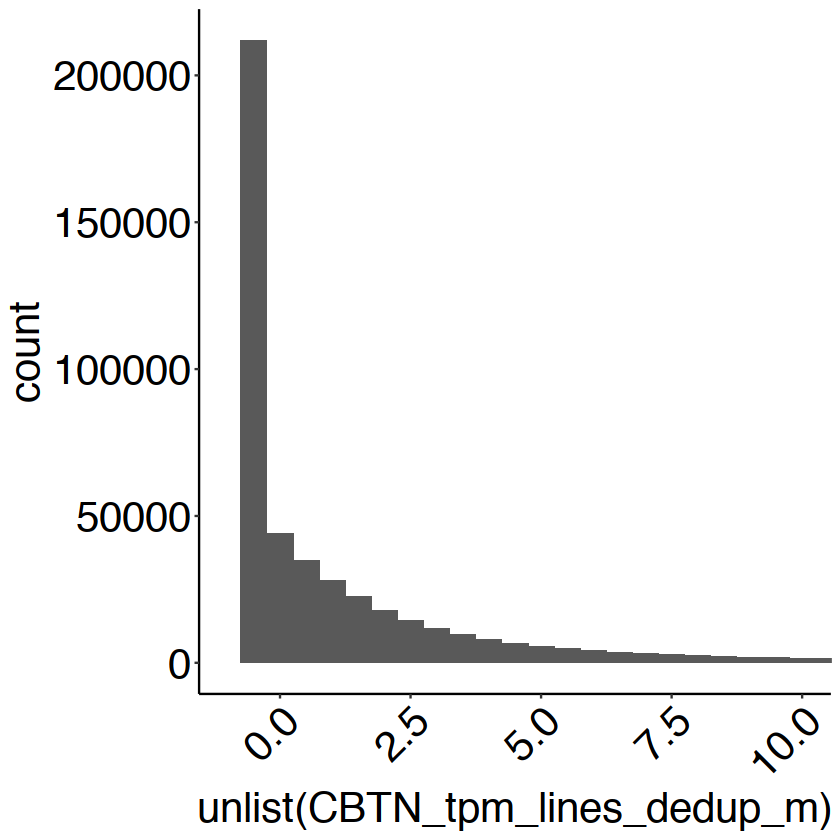

In [218]:
ggplot() + geom_histogram(aes(unlist(CBTN_tpm_lines_dedup_m)), binwidth = 0.5) + myaxis + myplot  +
coord_cartesian(xlim = c(-1,10))

In [219]:
lines_expressed_genes <- rownames(CBTN_tpm_lines_dedup_m)[rowSums(CBTN_tpm_lines_dedup_m > quantile(unlist(CBTN_tpm_lines_dedup_m), 0.75)) >= 1]

In [220]:
dim(CBTN_tpm_lines_dedup_m)
length(lines_expressed_genes)

[1] 21371    22

[1] 11195

11195 genes are expressed more than 75th percentile in at least one cellline 

## Bind all

In [221]:
nonimmune_genes <- c(nbl_nonimmune_genes_expressed,gojo_nonimmune_genes_expressed,
                     gillen_nonimmune_genes_expressed, pdx_expressed_genes, lines_expressed_genes)

In [222]:
length(nonimmune_genes)

[1] 45168

In [223]:
immune_genes_nontumour <- immune_genes[!immune_genes %in% nonimmune_genes]

In [224]:
length(immune_genes)

[1] 3041

In [225]:
length(immune_genes_nontumour)

[1] 791

In [226]:
save(immune_genes_nontumour, file = paste0(datapath, "TME_clusters/TME_immune_genes.RData"))